In [1]:
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# from torch.optim.lr_scheduler import StepLR

In [2]:
import math
import copy
import time
import random
from dataclasses import dataclass

In [3]:
from algo.dynamicProgramming import dynamicPlayer
from algo.iplayer import RandomPlayer, IPlayer
from algo.q_learning import QLearning
from algo.board import Board, GameState, MoveResult

In [4]:
device = torch.device(
    # "cuda" if torch.cuda.is_available() else
    # "mps" if torch.backends.mps.is_available() else
    "cpu"
)
device

device(type='cpu')

In [5]:
DEPLOYMENT_SIGN = -1

class DQN(nn.Module):
	"""
	Using structure similar to NNUE:
	https://www.chessprogramming.org/File:StockfishNNUELayers.png
	
	Observation space: hot-encoded board:
	for each of 18 cells we can be -2, -1, 0, 1, 2 (5 possibilities).
	In total it gives 18 * 5 = 90 possible inputs, out of which at most 12 are on.
	
	# Action space: 4 possible actions.
	Value function: 1 output. # https://www.reddit.com/r/reinforcementlearning/comments/1b1te73/help_me_understand_why_use_a_policy_net_instead/
	"""

	def __init__(self):
		super(DQN, self).__init__()

		layer_sizes = [
			90,
			50,
			50,
			1
		]

		layers = []
		prev_size = layer_sizes[0]
		for cur_size in layer_sizes[1:]:
			layer = nn.Linear(prev_size, cur_size)
			# nn.init.kaiming_uniform(layer.weight, nonlinearity='relu')
			layers.append(layer)
			prev_size = cur_size

		self.layers = nn.ModuleList(layers)

	def forward(self, board: Board) -> torch.Tensor:
		state = board.to_tensor(
			device,
			board.turn_sign != DEPLOYMENT_SIGN
		)
		for layer in self.layers[:-1]:
			state = F.relu(layer(state))
		return self.layers[-1](state)

In [6]:
def move_result_to_reward(move_result: MoveResult) -> float:
    return move_result.captured + move_result.promoted * 2

In [7]:
GAMMA = 0.99 # discount rate

@dataclass
class Action:
	action: tuple[tuple[int, int], tuple[int, int]]
	value: torch.Tensor

def q_s(dqn: DQN, current_state: Board) -> list[Action]:
	"""
	Return: list[(new_state, action, immediate_reward, value)]
	"""
	ret: list[Action] = []
	for s in current_state.get_possible_pos():
		for e in current_state.get_correct_moves(s):
			next_state = copy.deepcopy(current_state)
			immediate_reward = torch.tensor([
				move_result_to_reward(next_state.make_move(s, e))
			], device=device)
			value = dqn(next_state) * GAMMA + immediate_reward
			ret.append(Action((s, e), value))
	return ret

In [8]:
BATCH_SIZE = 128 # number of transitions sampled from the replay buffer

EPS_START = 0.9 # exploration rate
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005 # update rate
LR = 1e-4 # AdamW learning rate

steps_done = 0

def select_action(dqn: DQN, board: Board) -> Action:
	global steps_done
	sample = random.random()
	eps_threshold = EPS_END + (EPS_START - EPS_END) * \
		math.exp(-1. * steps_done / EPS_DECAY)
	steps_done += 1

	if sample > eps_threshold:
		with torch.no_grad():
			state_values = q_s(dqn, board)
			return max(state_values, key=lambda x: x.value.item())
					
	else:
		possible_moves = []
		for s in board.get_possible_pos():
			for e in board.get_correct_moves(s):
				possible_moves.append((s, e))
		return Action(
			random.choice(possible_moves),
			torch.tensor([0], device=device)
		)

In [9]:
def make_environment_step(state: Board, action: tuple[tuple[int, int], tuple[int, int]], enemy: IPlayer, current_step: int) -> tuple[Board, torch.Tensor]:
	"""
	Returns new state and reward for the given action.
	"""
	state = copy.deepcopy(state)
	cur_sign = state.turn_sign

	reward = move_result_to_reward(state.make_move(*action))

	while state.game_state == GameState.NOT_OVER and state.turn_sign != cur_sign:
		reward -= move_result_to_reward(state.make_move(*enemy.decide_move(state)))

	# if current_step > 10 and not we_captured:
	# 	reward -= 2
		
	if state.game_state != GameState.NOT_OVER:
		our_pieces = 0
		enemy_pieces = 0
		for _, piece in state:
			if piece == cur_sign:
				our_pieces += 1
			elif piece == -cur_sign:
				enemy_pieces += 1
			elif piece == 2 * cur_sign:
				our_pieces += 2
			elif piece == -2 * cur_sign:
				enemy_pieces += 2
			
		reward += 3 * our_pieces / (enemy_pieces + 1)

		if state.game_state == GameState.DRAW:
			reward -= 40
		elif state.game_state == GameState(cur_sign):
			reward += 40
		elif state.game_state == GameState(-cur_sign):
			reward -= 40
		else:
			raise ValueError("Unexpected game state")
	
	return state, torch.Tensor([reward])

In [10]:
def move_params(from_model: DQN, to_model: DQN):
	# to_model.load_state_dict(from_model.state_dict())
	target_net_state_dict = to_model.state_dict()
	policy_net_state_dict = from_model.state_dict()
	for key in policy_net_state_dict:
		target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
	to_model.load_state_dict(target_net_state_dict)

Q_1 = DQN().to(device) # to be updated often
Q_2 = DQN().to(device) # to be updated with TAU

# move_params(Q_1, Q_2)
# policy_net.load_state_dict(torch.load("dqn80.pth"))
Q_1.load_state_dict(Q_2.state_dict())


# only train Q_1
for param in Q_2.parameters():
	param.requires_grad = False

optimizer = optim.AdamW(Q_1.parameters(), lr=LR, amsgrad=True)
# scheduler = StepLR(optimizer, step_size=100, gamma=1)


@dataclass
class TransitionRecord:
	current_state: Board
	next_state: Board
	immediate_reward: torch.Tensor
	action: tuple[tuple[int, int], tuple[int, int]]

def optimize_model(memory: list[TransitionRecord]):
	if len(memory) < BATCH_SIZE:
		return
	
	q_value = []
	expected_q_value = []

	for r in random.sample(memory, BATCH_SIZE):
		q_value.append(next(
			a.value for a in q_s(Q_1, r.current_state) if a.action == r.action
		))

		if r.next_state.game_state == GameState.NOT_OVER:
			next_q_state_action = max(
				q_s(Q_2, r.next_state), key=lambda x: x.value.item()
			).action

			next_q_value = next(
				a.value for a in q_s(Q_1, r.next_state) if a.action == next_q_state_action
			)
		else:
			next_q_value = torch.tensor([0], device=device)

		expected_q_value.append((next_q_value * GAMMA) + r.immediate_reward)

	# Compute Huber loss
	criterion = nn.MSELoss()
	loss = criterion(
		torch.cat(q_value),
		torch.cat(expected_q_value)
	)

	# Optimize the model
	optimizer.zero_grad()
	loss.backward()
	# In-place gradient clipping
	torch.nn.utils.clip_grad_value_(Q_1.parameters(), 100)
	optimizer.step()

In [11]:
def run_game(net: DQN) -> int:
	enemy = RandomPlayer(random.randint(0, 10000))
	board = Board()
	while board.game_state == GameState.NOT_OVER:
		while board.game_state == GameState.NOT_OVER and board.turn_sign == 1:
			board.make_move(*enemy.decide_move(board))
		while board.game_state == GameState.NOT_OVER and board.turn_sign == -1:
			with torch.no_grad():
				state_values = max(q_s(net, board), key=lambda x: x.value.item())
				board.make_move(*state_values.action)
	
	pieces = 0
	for _, piece in board:
		pieces += piece != 0

	return (1 if board.game_state == GameState(-1) else -1) * pieces

In [12]:
max_score = 0
backup = None

In [13]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
	num_episodes = 600
else:
	num_episodes = 50
	
memory: list[TransitionRecord] = []

win_rate = []
number_of_steps = []
sum_number_of_steps = 0

q_enemy = QLearning("dqn80.pth")
rand_enemy = RandomPlayer(random.randint(0, 1000))

for i_episode in range(num_episodes):
	# Initialize the environment and get its state
	cur_state = Board()
	for _ in range(random.randint(0, 4)):
		cur_state.make_move(*rand_enemy.decide_move(cur_state))
	
	if i_episode < 500:
		enemy = rand_enemy
	else:
		enemy = q_enemy
	
	our_sign = cur_state.turn_sign
	
	num_steps = 0
	while True:
		num_steps += 1
		action = select_action(Q_2, cur_state)
		new_state, immediate_reward = make_environment_step(cur_state, action.action, enemy, num_steps)

		memory.append(TransitionRecord(
			cur_state, new_state,
			torch.tensor([immediate_reward], device=device),
			action.action
		))
		cur_state = new_state

		if cur_state.game_state != GameState.NOT_OVER:
			win_rate.append(cur_state.game_state == GameState(our_sign))
			break

	# Cropping memory
	# memory = memory[-5000:]
	
	if i_episode % 3 == 0:
		for _ in range(5):
			optimize_model(memory)
		
		move_params(Q_1, Q_2)

	number_of_steps.append(num_steps)
	sum_number_of_steps += num_steps
	# stats = [run_game(Q_2) for _ in range(20)]
	# a = sum(win_rate[-20:])
	# b = sum(x > 0 for x in stats)

	# if a * b > max_score:
	# 	max_score = a * b
	# 	backup = copy.deepcopy(Q_2)

	win_window = 20
	win_stat = sum(win_rate[-win_window:])

	print(time.strftime("%H:%M:%S"), f"Episode {i_episode} finished. {win_stat}/{win_window} | {sum_number_of_steps/len(number_of_steps)}")

print('Complete')

c:\user\docs\TUM\ReinforcementLearning\repos\romaAI\algo\q_learning.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


02:59:38 Episode 0 finished. 0/20 | 10.0
02:59:38 Episode 1 finished. 0/20 | 17.0
02:59:38 Episode 2 finished. 1/20 | 14.333333333333334
02:59:38 Episode 3 finished. 1/20 | 12.75
02:59:38 Episode 4 finished. 2/20 | 12.2
02:59:38 Episode 5 finished. 2/20 | 12.5
02:59:38 Episode 6 finished. 3/20 | 12.285714285714286
02:59:38 Episode 7 finished. 3/20 | 11.5
02:59:38 Episode 8 finished. 3/20 | 11.444444444444445
02:59:38 Episode 9 finished. 3/20 | 11.2
02:59:38 Episode 10 finished. 3/20 | 11.090909090909092
02:59:38 Episode 11 finished. 4/20 | 11.0
02:59:40 Episode 12 finished. 5/20 | 10.846153846153847
02:59:40 Episode 13 finished. 5/20 | 11.357142857142858
02:59:40 Episode 14 finished. 6/20 | 11.266666666666667
02:59:43 Episode 15 finished. 7/20 | 11.375
02:59:43 Episode 16 finished. 8/20 | 11.294117647058824
02:59:43 Episode 17 finished. 8/20 | 11.055555555555555
02:59:45 Episode 18 finished. 9/20 | 11.68421052631579
02:59:45 Episode 19 finished. 10/20 | 11.9
02:59:45 Episode 20 finishe

In [14]:
sum(win_rate) / len(win_rate)

0.605

In [15]:
len(win_rate)

600

In [16]:
sum(win_rate)

363

In [17]:
max_score

0

In [18]:
from matplotlib import pyplot as plt

(712, 1000)

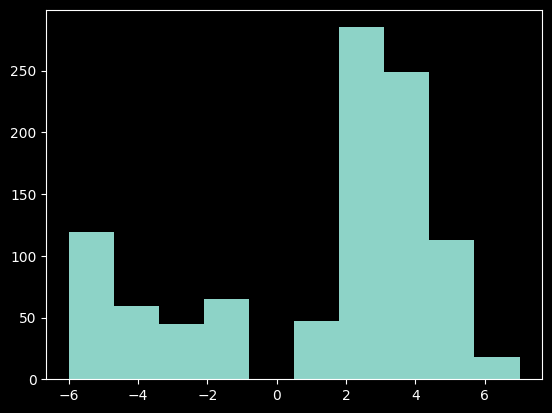

In [20]:
stats = [run_game(Q_2) for _ in range(1000)]

plt.hist(stats)
sum(x > 0 for x in stats), len(stats)

(732, 1000)

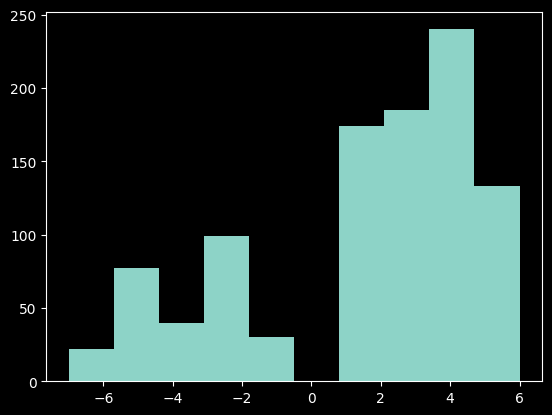

In [21]:
stats = [run_game(Q_2) for _ in range(1000)]

plt.hist(stats)
sum(x > 0 for x in stats), len(stats)

(737, 1000)

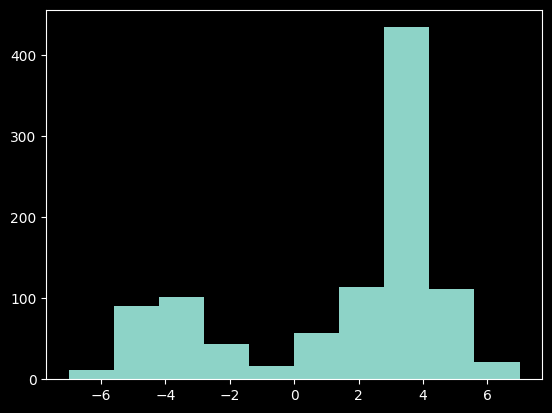

In [22]:
stats = [run_game(Q_2) for _ in range(1000)]

plt.hist(stats)
sum(x > 0 for x in stats), len(stats)